In [1]:
# 1. Standard setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# display settings
pd.set_option("display.max_columns", 50)
sns.set(style="whitegrid")

In [2]:
# 2.2 Simulate dataset
n_rows = 150_000  # choose 100k+ or any desired size

# demographics
ages = np.random.randint(18, 80, size=n_rows)
genders = np.random.choice(["Male", "Female", "Other"], size=n_rows, p=[0.48, 0.48, 0.04])
income = np.random.lognormal(mean=10, sigma=0.6, size=n_rows)  # roughly skewed income distribution
# cap income for realism
income = np.clip(income, 20_000, 200_000)

regions = np.random.choice(
    ["North", "South", "East", "West", "Central", "International"],
    size=n_rows,
    p=[0.2, 0.2, 0.2, 0.2, 0.1, 0.1],
)

# products: Schweppes or San Pellegrino
brands = np.random.choice(
    ["Schweppes", "San Pellegrino"],
    size=n_rows,
    p=[0.6, 0.4]  # arbitrary split; adjust if you have real market share
)

# base sales figure, e.g., monthly or weekly per-customer purchase value
# introduce brand effect and demographic effects
base_sales = np.random.normal(loc=50, scale=15, size=n_rows)  # base in dollars
brand_effect = np.where(brands == "San Pellegrino", 1.15, 1.0)  # e.g., slightly higher ticket
age_effect = 1 + (ages - 35) * 0.002  # small effect per year of age
income_effect = 1 + (income - 50_000) / 200_000  # higher income slightly increases spend
region_effect_map = {
    "North": 1.0,
    "South": 0.95,
    "East": 1.05,
    "West": 1.0,
    "Central": 0.98,
    "International": 1.10,
}
region_effect = np.array([region_effect_map[r] for r in regions])

# simulate sales value
sales = base_sales * brand_effect * age_effect * income_effect * region_effect
# ensure positive
sales = np.maximum(sales, 1.0)

# profit margin: simulate as percentage of sales, with brand and region variation
# e.g., San Pellegrino may have a slightly higher margin due to premium positioning
base_margin_pct = np.random.normal(loc=0.25, scale=0.05, size=n_rows)  # around 25% margin
brand_margin_adj = np.where(brands == "San Pellegrino", 0.03, 0.0)
# region costs
region_margin_adj = np.array([0.0 if r != "International" else -0.02 for r in regions])

margin_pct = base_margin_pct + brand_margin_adj + region_margin_adj
# clip between 0 and 0.5 (0%–50%)
margin_pct = np.clip(margin_pct, 0.05, 0.5)

# profit dollar value
profit = sales * margin_pct

# create DataFrame
df = pd.DataFrame({
    "Age": ages,
    "Gender": genders,
    "Income": income,
    "Region": regions,
    "Brand": brands,
    "Sales": sales,
    "Profit": profit,
    "MarginPct": margin_pct
})

df.head()

,Age,Gender,Income,Region,Brand,Sales,Profit,MarginPct
0,56,Female,30139.990069,Central,Schweppes,28.088717,6.365574,0.226624
1,69,Male,49045.972239,West,Schweppes,41.945188,11.457533,0.273155
2,46,Male,20000.000000,East,San Pellegrino,87.671833,26.729631,0.304883
3,32,Male,20000.000000,West,Schweppes,22.886699,5.515330,0.240984
4,60,Other,20000.000000,North,San Pellegrino,53.897445,14.654803,0.271902


In [3]:
# 3.1 Load your actual data
# df = pd.read_csv("your_path/sales_data.csv")

# Example: ensure required columns exist
required_cols = ["Age", "Gender", "Income", "Region", "Brand", "Sales", "Profit", "MarginPct"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

In [4]:
df.describe(include="all")

,Age,Gender,Income,Region,Brand,Sales,Profit,MarginPct
count,150000.000000,150000,150000.000000,150000,150000,150000.000000,150000.000000,150000.000000
unique,NaN,3,NaN,6,2,NaN,NaN,NaN
top,NaN,Female,NaN,East,Schweppes,NaN,NaN,NaN
freq,NaN,72142,NaN,30171,90041,NaN,NaN,NaN
mean,48.529860,NaN,29161.832615,NaN,NaN,49.204436,12.825527,0.259844
std,17.869213,NaN,15074.827221,NaN,NaN,16.062360,5.106115,0.052446
min,18.000000,NaN,20000.000000,NaN,NaN,1.000000,0.126861,0.050000
25%,33.000000,NaN,20000.000000,NaN,NaN,38.255783,9.194518,0.224380
50%,48.000000,NaN,21977.801512,NaN,NaN,48.469590,12.255471,0.259767
75%,64.000000,NaN,32947.817050,NaN,NaN,59.239294,15.826416,0.295263


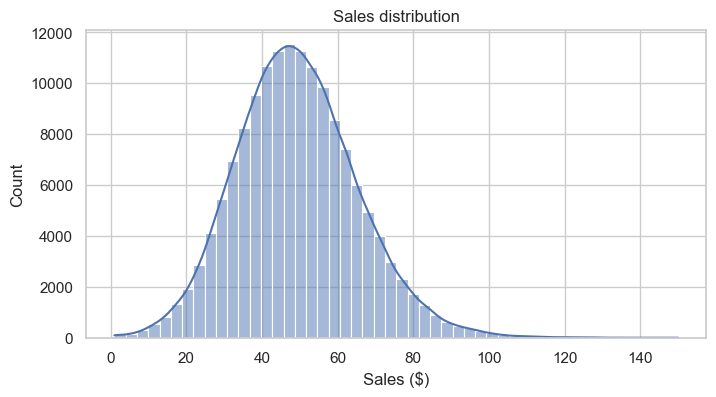

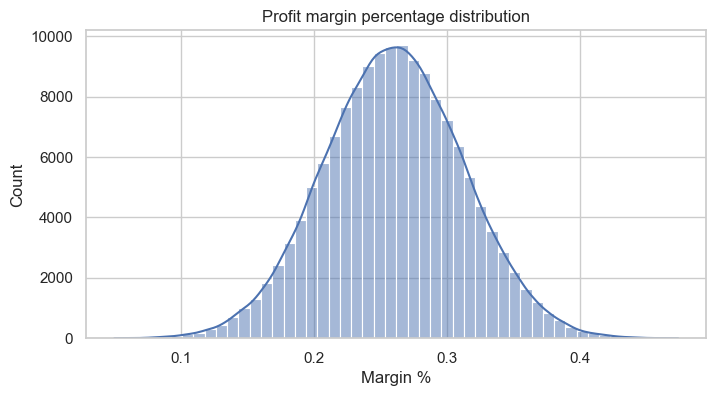

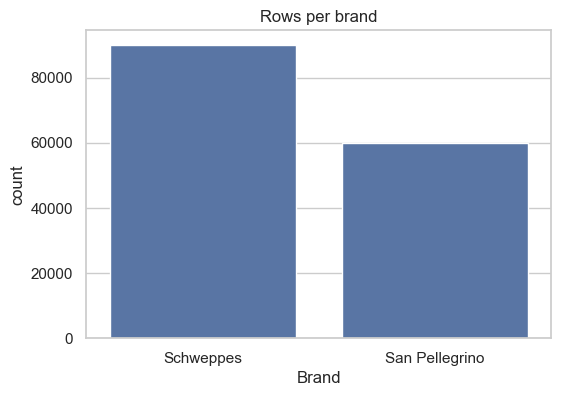

In [5]:
# Sales distribution
plt.figure(figsize=(8,4))
sns.histplot(df["Sales"], bins=50, kde=True)
plt.title("Sales distribution")
plt.xlabel("Sales ($)")
plt.show()

# Margin distribution
plt.figure(figsize=(8,4))
sns.histplot(df["MarginPct"], bins=50, kde=True)
plt.title("Profit margin percentage distribution")
plt.xlabel("Margin %")
plt.show()

# Brand counts
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="Brand")
plt.title("Rows per brand")
plt.show()

Brand
San Pellegrino    53.416069
Schweppes         46.399877
Name: Sales, dtype: float64
Brand
San Pellegrino    0.277794
Schweppes         0.247890
Name: MarginPct, dtype: float64


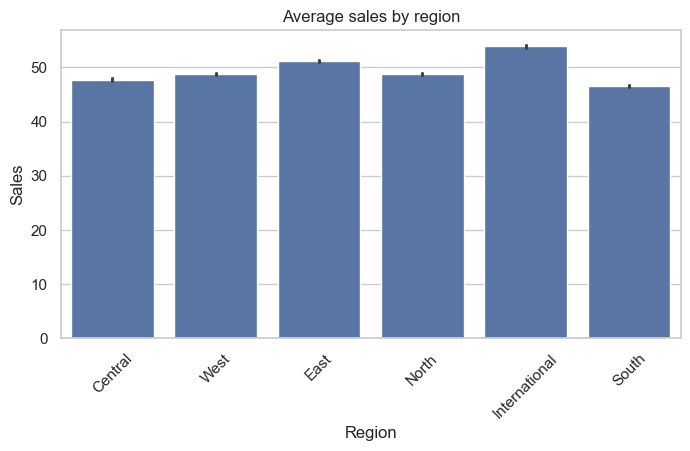

In [6]:
# Average sales by brand
print(df.groupby("Brand")["Sales"].mean())

# Average margin by brand
print(df.groupby("Brand")["MarginPct"].mean())

# Sales by region
plt.figure(figsize=(8,4))
sns.barplot(data=df, x="Region", y="Sales", estimator=np.mean)
plt.xticks(rotation=45)
plt.title("Average sales by region")
plt.show()

In [7]:
# One-hot encode Brand, Gender, Region
df_encoded = pd.get_dummies(df, columns=["Brand", "Gender", "Region"], drop_first=True)

# Features and target for predicting Sales
X = df_encoded.drop(columns=["Sales", "Profit", "MarginPct"])
y_sales = df_encoded["Sales"]

# Similarly, for predicting Profit or MarginPct if needed:
y_profit = df_encoded["Profit"]
y_margin = df_encoded["MarginPct"]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_sales, test_size=0.2, random_state=RANDOM_SEED
)

In [9]:
lr = LinearRegression()
lr.fit(X_train, y_train)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [10]:
y_pred_lr = lr.predict(X_test)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Linear Regression RMSE: {rmse_lr:.2f}")
print(f"Linear Regression R^2: {r2_lr:.4f}")

Linear Regression RMSE: 14.73
Linear Regression R^2: 0.1483


In [11]:
coef_df = pd.DataFrame({
    "feature": X.columns,
    "coef": lr.coef_
}).sort_values(by="coef", key=lambda s: np.abs(s), ascending=False)
coef_df.head(10)

,feature,coef
2,Brand_Schweppes,-7.026747
6,Region_International,5.937155
5,Region_East,3.426209
8,Region_South,-1.372201
7,Region_North,1.057543
9,Region_West,0.964331
4,Gender_Other,0.130378
0,Age,0.097776
3,Gender_Male,0.061713
1,Income,0.000280


In [12]:
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=RANDOM_SEED,
    n_jobs=-1
)
rf.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",10
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples 

In [13]:
y_pred_rf = rf.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest RMSE: {rmse_rf:.2f}")
print(f"Random Forest R^2: {r2_rf:.4f}")

Random Forest RMSE: 14.78
Random Forest R^2: 0.1421


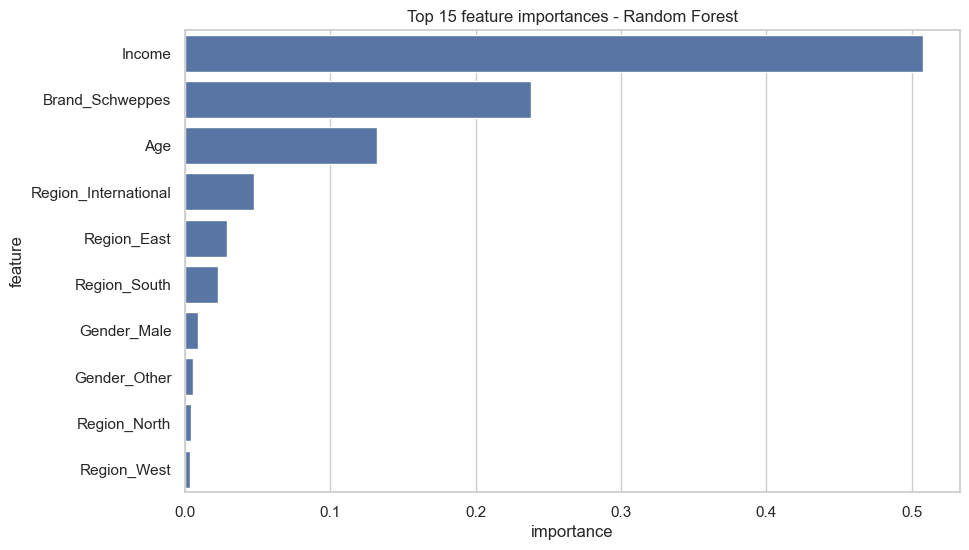

In [14]:
feat_imp = pd.DataFrame({
    "feature": X.columns,
    "importance": rf.feature_importances_
}).sort_values(by="importance", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=feat_imp.head(15), x="importance", y="feature")
plt.title("Top 15 feature importances - Random Forest")
plt.show()

In [ ]:
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [8, 12, 16],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

grid_rf = GridSearchCV(
    RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1),
    param_grid,
    cv=3,
    scoring="r2",
    verbose=1
)
grid_rf.fit(X_train, y_train)

print("Best params:", grid_rf.best_params_)
best_rf = grid_rf.best_estimator_

# Evaluate best model
y_pred_best = best_rf.predict(X_test)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2_best = r2_score(y_test, y_pred_best)
print(f"Tuned RF RMSE: {rmse_best:.2f}")
print(f"Tuned RF R^2: {r2_best:.4f}")

Fitting 3 folds for each of 24 candidates, totalling 72 fits


In [ ]:
# example for Profit
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(
    X, y_profit, test_size=0.2, random_state=RANDOM_SEED
)

rf_profit = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1)
rf_profit.fit(X_train_p, y_train_p)
y_pred_profit = rf_profit.predict(X_test_p)

print("Profit RF R^2:", r2_score(y_test_p, y_pred_profit))
print("Profit RF RMSE:", np.sqrt(mean_squared_error(y_test_p, y_pred_profit)))

In [ ]:
# sample subset for plotting
plot_df = pd.DataFrame({
    "true_sales": y_test,
    "pred_sales_lr": y_pred_lr,
    "pred_sales_rf": y_pred_rf
}).reset_index(drop=True).sample(500, random_state=RANDOM_SEED)

plt.figure(figsize=(8,8))
plt.scatter(plot_df["true_sales"], plot_df["pred_sales_lr"], alpha=0.4, label="LinearReg")
plt.scatter(plot_df["true_sales"], plot_df["pred_sales_rf"], alpha=0.4, label="RandomForest")
plt.plot([plot_df["true_sales"].min(), plot_df["true_sales"].max()],
         [plot_df["true_sales"].min(), plot_df["true_sales"].max()], 'k--', lw=2)
plt.xlabel("True Sales")
plt.ylabel("Predicted Sales")
plt.legend()
plt.title("True vs Predicted Sales")
plt.show()

In [ ]:
# Save processed data for later use
df.to_csv("simulated_sales_dataset.csv", index=False)